## **Executing the MIS algorithm on a better emulator**

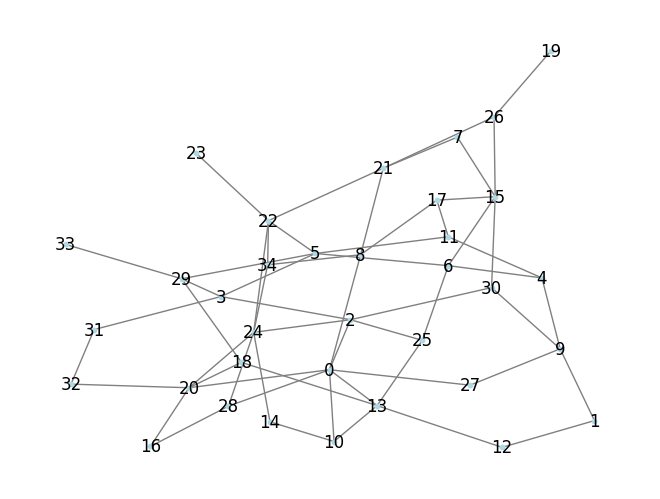

In [1]:
from QMIS_code.pulse_utils import Pulse_constructor
import networkx as nx
import matplotlib.pyplot as plt

best_pulse = Pulse_constructor(4000, "Waveform")


nb_nodes = 35
p = 0.1
graph = big_graph = nx.erdos_renyi_graph(n=nb_nodes, p=p, seed=42)


mapping = {node: str(node) for node in graph.nodes()}
graph = nx.relabel_nodes(graph, mapping)

pos = nx.spring_layout(graph, k=0.1, seed=42)

nx.draw(
    graph,
    with_labels=True,
    node_color="lightblue",
    node_size=10, #small nodes to see the edges
    edge_color="gray",
    pos=pos,
)
plt.savefig("35_atoms_graph.pdf")
plt.show()

## Creating the sequence to emulate with this given graph

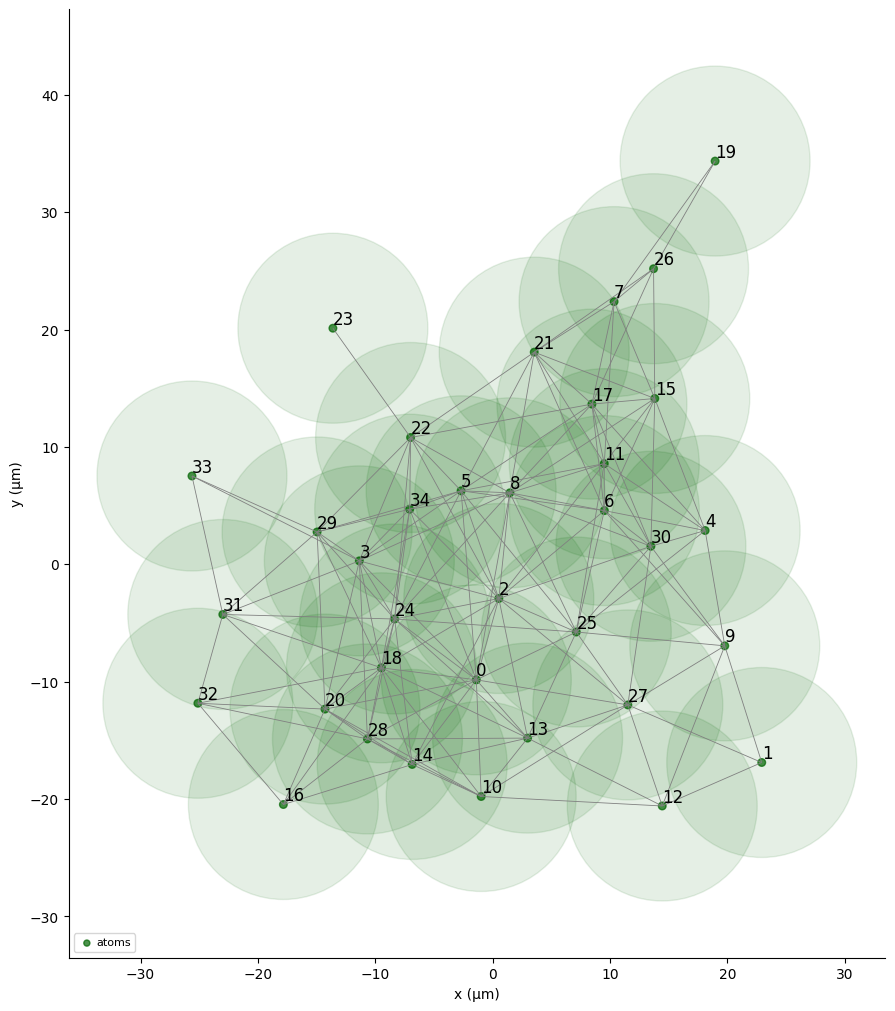

<Figure size 640x480 with 0 Axes>

In [ ]:
from pulser.devices import DigitalAnalogDevice
from pulser import Register, Sequence
from QMIS_code.QMIS_utils import find_minimal_radius
import numpy as np
from scipy.spatial.distance import pdist


R_blockade = find_minimal_radius(graph, pos)
coord = np.array(list(pos.values()))

val = np.min(pdist(coord))

min_dist = DigitalAnalogDevice.min_atom_distance
max_dist = DigitalAnalogDevice.max_radial_distance
coord *= min_dist/val
R_blockade *= min_dist/val
reg = Register.from_coordinates(coord)

reg.draw(draw_graph=True, blockade_radius=R_blockade, draw_half_radius=True)



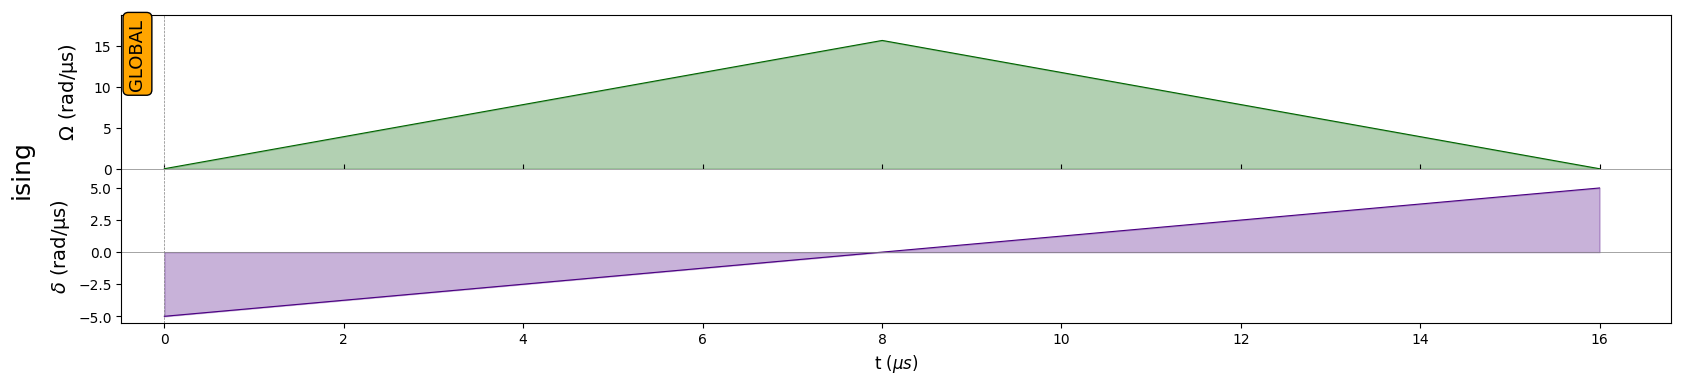

<Figure size 640x480 with 0 Axes>

In [4]:
from QMIS_code.pulse_utils import Pulse_constructor

Omega_pulse_max = DigitalAnalogDevice.channels["rydberg_global"].max_amp
Omega = min(Omega_pulse_max-0.001, R_blockade)

seq = Sequence(reg, DigitalAnalogDevice)

pulse = Pulse_constructor(16000, "Rise_fall")

seq.declare_channel("ising", "rydberg_global")
seq.add(pulse(Omega), "ising")
seq.draw()
plt.savefig("seq_35_atoms.pdf")

In [5]:
shots = 1000
path = "/Users/ludo/library/cloudstorage/onedrive-personnel/Documents/ludovic/école/université/automne_24/bsq201/ReQpex/"

## **Finding the MIS with Big_QMIS** (Quantum_MIS, QAA)

In [6]:
from Big_QMIS import BIG_QMIS

solver = BIG_QMIS(graph, 12)
qaa_result = solver.run(pulse, shots = shots)

print(qaa_result)

['7', '8', '11', '19', '23', '25', '16', '18', '30', '12', '32', '33']


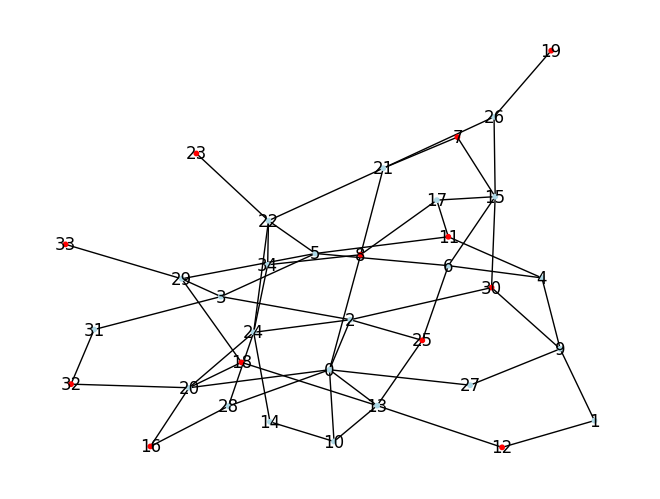

In [7]:
#the red nodes are part of the maximal independant set and the blue nodes are not part of the maximal independant set
nodes_color = ["red" if node in qaa_result else "lightblue" for node in graph.nodes]

nx.draw(graph, pos = pos, with_labels = True, node_color = nodes_color, node_size=10)
plt.savefig("QAA_35_atoms.pdf")
plt.show()

## **Finding the MIS with the Big_QMIS (QAOA)**

## **Finding the MIS with a classical alrogithm**

In [32]:
from Find_MIS_discs import Find_MIS_discs
classical = Find_MIS_discs(graph)
res_dict = classical.run(
    shots=shots, path=path
)
best_bitstring_class = max(zip(res_dict.values(), res_dict.keys()))[1]

print(best_bitstring_class)
print(res_dict)


10010000010110011011010111000000110
{'01101001001000000111001000011001010': 1, '10000010000010001101010110000111000': 1, '01100011000101100000100100111001011': 1, '00011001000010100101101001011010010': 1, '01000011000001101101000100010110101': 1, '00000001110110100001000101001100100': 1, '01001000000001100101110100011111001': 1, '10000011010010101110000100100001011': 1, '00011001001010000100100101111010011': 2, '01101100000000111011010100010000111': 1, '00100100010010111011010100000001011': 2, '00011000000010100111010101011010111': 2, '00000101011010001111000111000001010': 1, '00000000011110010001110101001101001': 1, '10001101000010101110000101100011011': 4, '00100011110101100001100100001101000': 1, '01010011000101101001000100010010111': 1, '00001101000010100110000101111011011': 1, '00100000000110111011010100010000111': 1, '00010011001010000100100100111010011': 1, '10000001000110101001001001000110100': 1, '01000011101100000001100100011111000': 1, '01011000001000000111010101011010111': 

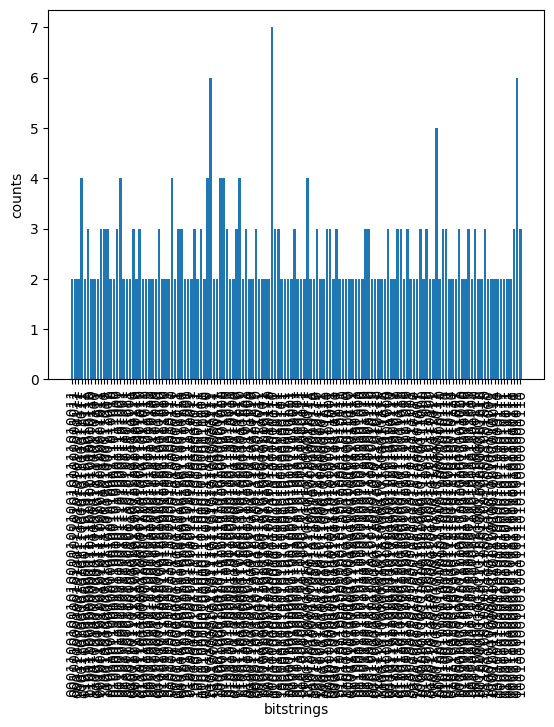

In [36]:
file_name = "classical_histo_35_atoms.pdf"
most_freq = {k: v for k, v in res_dict.items() if v > 0.001 * shots}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel("counts")
plt.xlabel("bitstrings")
if file_name != "":
    plt.savefig(file_name)
plt.show()

In [9]:
classical_result = []
for j in range(len(best_bitstring_class)):
    if best_bitstring_class[j] == "1":
        classical_result.append(str(j))

print("nodes contained in the maximal independant set: ", classical_result)

nodes contained in the maximal independant set:  ['0', '1', '4', '5', '14', '16', '17', '18', '19', '21', '23', '25', '30', '31', '33', '34']


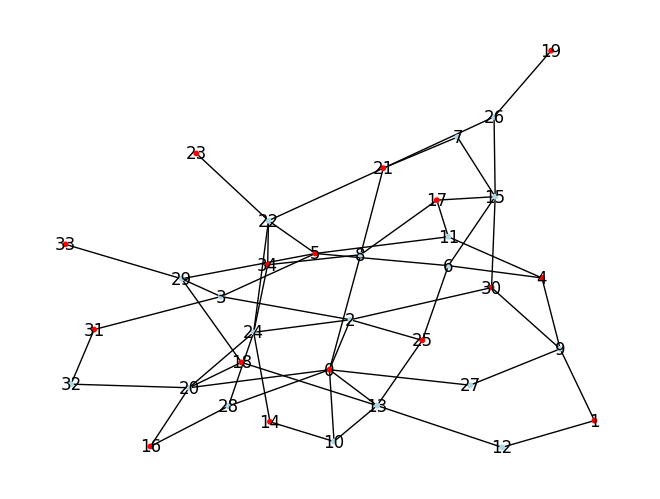

In [10]:
#the red nodes are part of the maximal independant set and the blue nodes are not part of the maximal independant set
node_colors = ["red" if node in classical_result else "lightblue" for node in graph.nodes]

nx.draw(graph, pos = pos, with_labels = True, node_color = node_colors, node_size = 10)
plt.savefig("classical_35_atoms.pdf")
plt.show()

## **Running the emulation on the cloud**

In [11]:
from pulser_pasqal import PasqalCloud
from pulser.backends import EmuTNBackend
from pulser import EmulatorConfig
import dataclasses
import json

PROJECT_ID = "3e1ed7fd-69a7-42c6-b543-98e738c25b4c"
USERNAME = "Ludovic.Marcotte2@USherbrooke.ca"
PASSWORD = "AFN2hwt0vgn0vqz!afy"
connection = PasqalCloud(
        username=USERNAME, 
        project_id=PROJECT_ID,  
        password=PASSWORD, 
    )

In [12]:
#setting options of the EmuTN backend
backend_options = {'max_bond_dim' : 500} #this makes the emulator faster but limits how accurate it is
#do not go beyond 500!

#then we define the Emulator Configuration
emu_tn_config = EmulatorConfig(backend_options=backend_options, 
                               sampling_rate=0.1, 
                               evaluation_times='Final')

#we initialize the emu_tn backend, using our connection and our sequence (the same as before!)
tn_bknd = EmuTNBackend(
    seq, connection=connection, config=emu_tn_config
)



In [13]:
tn_results = tn_bknd.run([{'runs' : shots}])

/Users/ludo/anaconda3/envs/pasqal/lib/python3.11/site-packages/pulser/register/register.py:482: UserWarning: Register serialization to an abstract representation irreversibly converts all qubit ID's to strings.
  names = stringify_qubit_ids(self._ids)


In [19]:
batch_id = tn_results.batch_id
job_ids = tn_results.job_ids
print('batch id:', batch_id)
print('job id:', job_ids)

batch id: 3dfc489c-93ca-4218-8548-e351c5534400
job id: ['e39bad1f-50af-4814-ab31-2e76924f0b9b']


In [24]:
connection._get_batch_status(batch_id=batch_id)

<BatchStatus.DONE: 3>

In [25]:
try:
    results = connection._fetch_result(batch_id=batch_id, job_ids=job_ids)
    all_count_dicts = []
    for res in results:
        all_count_dicts.append(res.bitstring_counts)
    print(all_count_dicts)
except:
    print('job not finished running')

# #storing these results in a json file.
# with open('result.json', 'w') as fp:
#     json.dump(all_count_dicts, fp)

[{'00000010011010001011010100000001011': 6, '01001000001000001011010101000000111': 5, '00001100001010001001010111000000110': 3, '00000001011110001011000101000000111': 3, '01111000001000001001010100010000110': 3, '00001000101010001001010111000000110': 3, '01111000001000000001010100010000110': 3, '01001000001000001001010100010001011': 3, '00000100011010011011000101000000110': 3, '01011001101000001001000100010000110': 3, '01001000001000001011010101000001011': 2, '01111000001000000101000100110000110': 2, '00011000101010001001010101100000110': 2, '00001000101010011001000101000100110': 2, '01001000101000011011000101000000110': 2, '00000100011010011011000100000001010': 2, '01001001001000001001001111000000110': 2, '01011000001000001001010101000000110': 2, '00000100011010001101000111000000110': 2, '00110000011010011001010100000001010': 2, '01001100001000001111000101100000110': 2, '01011000101000001001010100010000110': 2, '00101000001010011001000100000100010': 2, '0000001001101000101101010000000

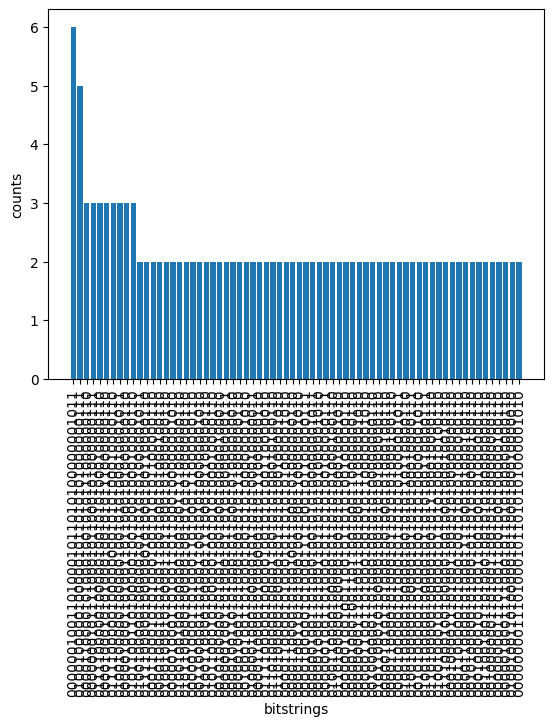

In [30]:
file_name = "histo_35_atoms_emuTN.pdf"

most_freq = {k: v for k, v in all_count_dicts[0].items() if v > 0.001 * shots}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel("counts")
plt.xlabel("bitstrings")
if file_name != "":
    plt.savefig(file_name)
plt.show()

In [26]:
best_bitstring = max(zip(all_count_dicts[0].values(), all_count_dicts[0].keys()))[1]
print("best bitstring in the histogram: ", best_bitstring)

emu_TN_results = []
for j in range(len(best_bitstring)):
    if best_bitstring[j] == "1":
        emu_TN_results.append(str(j))

print("nodes contained in the maximal independant set: ", emu_TN_results)

best bitstring in the histogram:  00000010011010001011010100000001011
nodes contained in the maximal independant set:  ['6', '9', '10', '12', '16', '18', '19', '21', '23', '31', '33', '34']


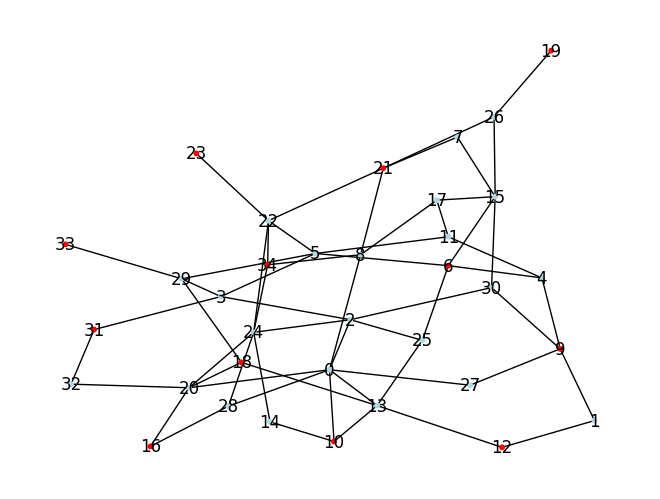

In [31]:
#the red nodes are part of the maximal independant set and the blue nodes are not part of the maximal independant set
node_colors = ["red" if node in emu_TN_results else "lightblue" for node in graph.nodes]

nx.draw(graph, pos = pos, with_labels = True, node_color = node_colors, node_size = 10)
plt.savefig("emuTN_35_atoms.pdf")
plt.show()


## **Comparaison des MIS obtenus**

In [28]:
print("Résultats obtenus à l'aide du 'QAA': ", qaa_result)
print("Grandeur du MIS: ", len(qaa_result))
print("#########################################################################")

print("Résultats obtenus à l'aide du 'QAOA': ")
print("Grandeur du MIS: ")
print("#########################################################################")

print("Résultats obtenus à l'aide de la méthode classique: ", classical_result)
print("Grandeur du MIS: ", len(classical_result))
print("#########################################################################")

print("Résultats obtenus à l'aide de emu_TN: ", emu_TN_results)
print("Grandeur du MIS: ", len(emu_TN_results))
print("#########################################################################")

Résultats obtenus à l'aide du 'QAA':  ['7', '8', '11', '19', '23', '25', '16', '18', '30', '12', '32', '33']
Grandeur du MIS:  12
#########################################################################
Résultats obtenus à l'aide du 'QAOA': 
Grandeur du MIS: 
#########################################################################
Résultats obtenus à l'aide de la méthode classique:  ['0', '1', '4', '5', '14', '16', '17', '18', '19', '21', '23', '25', '30', '31', '33', '34']
Grandeur du MIS:  16
#########################################################################
Résultats obtenus à l'aide de emu_TN:  ['6', '9', '10', '12', '16', '18', '19', '21', '23', '31', '33', '34']
Grandeur du MIS:  12
#########################################################################
